<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/google_resnet_120_v_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 64
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/rust_cro/1424_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1424_2.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1425_2.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1427.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1427_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1429.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1430.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1430_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1431.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1431_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1434.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1434_1.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1436.jpg
/content/drive/My Drive/coffee_dataset/rust_cro/1436_1.jpg
/content/drive/My D

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

In [9]:
from keras.utils.all_utils import to_categorical
y_train_one_hot = to_categorical(y_train)

### train test validate splite

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,y_train_one_hot,test_size=0.20,shuffle=True,random_state=42,stratify=y_train_one_hot)

In [12]:

print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(4944, 64, 64, 3) ---- (4944, 7)
(1236, 64, 64, 3) ---- (1236, 7)


In [13]:
x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

### GoogleNet

In [14]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [15]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [16]:
input_layer = Input(shape=(64, 64, 3))

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [17]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [18]:
inp = Input(shape = (64,64,3))
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [19]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.35)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.40)(out)
#out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(7,activation='softmax')(out)

In [20]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [21]:
e_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = e_model.fit([x_tr,x_tr],y_tr,epochs=120,validation_data=([x_v,x_v],y_v))

Epoch 1/120
155/155 [==============================] - 24s 67ms/step - loss: 0.9869 - accuracy: 0.5744 - val_loss: 0.7910 - val_accuracy: 0.6052
Epoch 2/120
155/155 [==============================] - 9s 56ms/step - loss: 0.6012 - accuracy: 0.7128 - val_loss: 0.5782 - val_accuracy: 0.7087
Epoch 3/120
155/155 [==============================] - 9s 56ms/step - loss: 0.4756 - accuracy: 0.7627 - val_loss: 0.5370 - val_accuracy: 0.7654
Epoch 4/120
155/155 [==============================] - 9s 56ms/step - loss: 0.4061 - accuracy: 0.8018 - val_loss: 0.3753 - val_accuracy: 0.8414
Epoch 5/120
155/155 [==============================] - 9s 57ms/step - loss: 0.3910 - accuracy: 0.8188 - val_loss: 0.3018 - val_accuracy: 0.8770
Epoch 6/120
155/155 [==============================] - 9s 57ms/step - loss: 0.3300 - accuracy: 0.8564 - val_loss: 0.3240 - val_accuracy: 0.8819
Epoch 7/120
155/155 [==============================] - 9s 58ms/step - loss: 0.3043 - accuracy: 0.8748 - val_loss: 0.2803 - val_accuracy

### plot the result

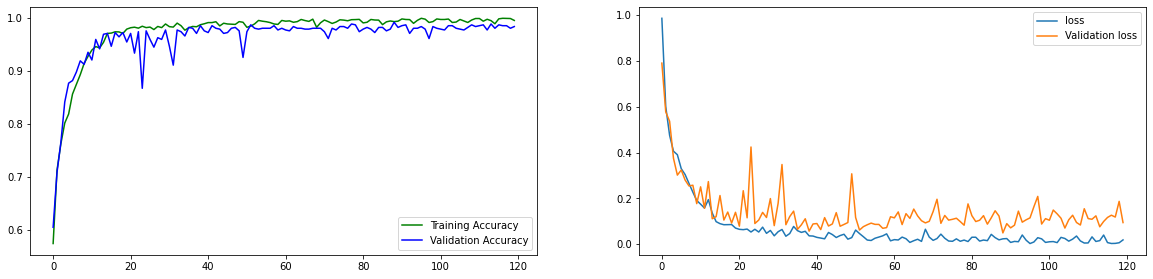

In [30]:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure(figsize=(20,15))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acc, 'g', label = 'Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label= 'Validation Accuracy')
  #plt.title(f'Training and Validation accuray {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, loss,'', label = 'loss')
  plt.plot(epochs, val_loss,'', label = 'Validation loss')
  #plt.title(f'Training and Validation loss {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2)
  #show the graph
  plt.show()

### make prdiction and do confusion matrix

In [23]:
labeles = ['CBD','CB_Healthy','Healthy','Cercospora','Mold','Phoma','CLR']

### confusion matrix Training

In [24]:
pred_tr = e_model.predict([x_tr,x_tr])
round_pred_tr = np.argmax(pred_tr,axis=-1)
y_tr_r = np.argmax(y_tr,axis=-1)
#print("Acuracy of the Testing is : " ,pred)

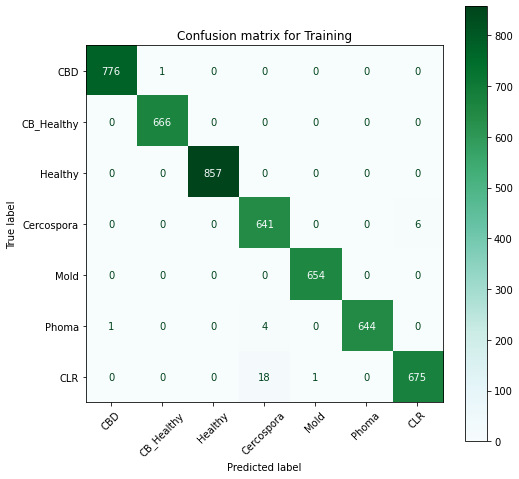

In [35]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tr_r, round_pred_tr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Training")
plt.show()

In [34]:
print(classification_report(y_tr_r,round_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       777
           1       1.00      1.00      1.00       666
           2       1.00      1.00      1.00       857
           3       0.97      0.99      0.98       647
           4       1.00      1.00      1.00       654
           5       1.00      0.99      1.00       649
           6       0.99      0.97      0.98       694

    accuracy                           0.99      4944
   macro avg       0.99      0.99      0.99      4944
weighted avg       0.99      0.99      0.99      4944



### validation confusion matrix

In [26]:
pred_v = e_model.predict([x_v,x_v])
round_pred_v = np.argmax(pred_v,axis=-1)
y_v_r = np.argmax(y_v,axis=-1)

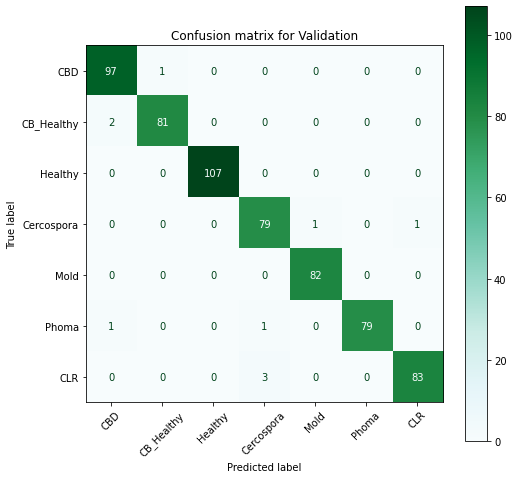

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        98
           1       0.99      0.98      0.98        83
           2       1.00      1.00      1.00       107
           3       0.95      0.98      0.96        81
           4       0.99      1.00      0.99        82
           5       1.00      0.98      0.99        81
           6       0.99      0.97      0.98        86

    accuracy                           0.98       618
   macro avg       0.98      0.98      0.98       618
weighted avg       0.98      0.98      0.98       618



In [36]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_v_r, round_pred_v)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Validation")
plt.show()
print(classification_report(y_v_r,round_pred_v))

### confusion matrix Testing

In [28]:
pred_t = e_model.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)

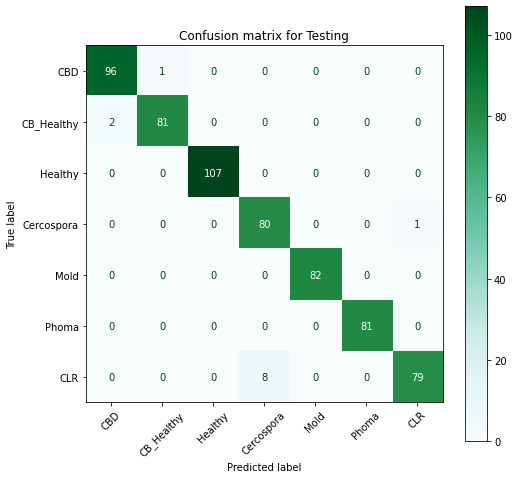

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        97
           1       0.99      0.98      0.98        83
           2       1.00      1.00      1.00       107
           3       0.91      0.99      0.95        81
           4       1.00      1.00      1.00        82
           5       1.00      1.00      1.00        81
           6       0.99      0.91      0.95        87

    accuracy                           0.98       618
   macro avg       0.98      0.98      0.98       618
weighted avg       0.98      0.98      0.98       618



In [37]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tes_r, round_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Testing")
plt.show()
print(classification_report(y_tes_r,round_pred_t))